# Training an image classifier

In [1]:
#libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import os
import random
import shutil
import matplotlib.pyplot as plt

As an example of a state-of-the-art deep convolutional neural network, in this exercise we will use the Big Transfer (BiT) approach (see <a href="https://arxiv.org/abs/1912.11370">paper</a>) to build a binary image classifier. In case you are not familiar with tensorflow you can find more information in the <a href="https://www.tensorflow.org/tutorials">tensorflow tutorials</a>.

**Using the model**

To test the approach on your own image classification data set, upload your images as a zip file. The zip file must be called images.zip and contain a single folder "images" with subfolders "train" and "test". Both "train" and "test" must contain further subfolders "class1" and "class2", and these must contain the actual images. Images should be approximately square.



In [4]:
#Upload zip file with image data.
#Existing zip files are cleared first to avoid file name clashes
from google.colab import files
!rm /content/*.zip
uploaded = files.upload()

Saving images.zip to images.zip


Archive:  /content/images.zip
   creating: /content/images/
   creating: /content/images/test/
   creating: /content/images/test/class0/
  inflating: /content/images/test/class0/row-10-col-10211.jpg  
  inflating: /content/images/test/class0/row-10-col-1062.jpg  
  inflating: /content/images/test/class0/row-11-col-10221.jpg  
  inflating: /content/images/test/class0/row-11-col-1072.jpg  
  inflating: /content/images/test/class0/row-12-col-10231.jpg  
  inflating: /content/images/test/class0/row-12-col-1082.jpg  
   creating: /content/images/test/class1/
  inflating: /content/images/test/class1/row-10-col-1210.jpg  
  inflating: /content/images/test/class1/row-10-col-161.jpg  
  inflating: /content/images/test/class1/row-11-col-1220.jpg  
  inflating: /content/images/test/class1/row-11-col-171.jpg  
  inflating: /content/images/test/class1/row-12-col-1230.jpg  
  inflating: /content/images/test/class1/row-12-col-181.jpg  
   creating: /content/images/test/class2/
  inflating: /content/i

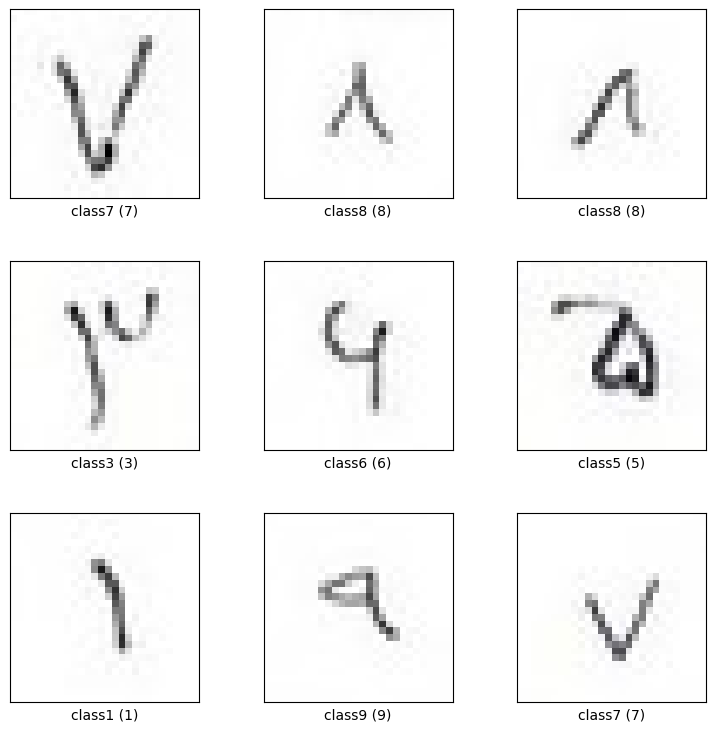

Epoch 1/10
10/10 [==============================] - 14s 201ms/step - loss: 2.2685 - accuracy: 0.2100 - val_loss: 2.1315 - val_accuracy: 0.2667
Epoch 2/10
10/10 [==============================] - 1s 64ms/step - loss: 2.0646 - accuracy: 0.2800 - val_loss: 1.8808 - val_accuracy: 0.2833
Epoch 3/10
10/10 [==============================] - 1s 65ms/step - loss: 1.6952 - accuracy: 0.4200 - val_loss: 1.5767 - val_accuracy: 0.4667
Epoch 4/10
10/10 [==============================] - 1s 66ms/step - loss: 1.5885 - accuracy: 0.5000 - val_loss: 1.4054 - val_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 1s 65ms/step - loss: 1.4745 - accuracy: 0.5200 - val_loss: 1.3847 - val_accuracy: 0.5167
Epoch 6/10
10/10 [==============================] - 1s 64ms/step - loss: 1.2173 - accuracy: 0.6200 - val_loss: 1.2534 - val_accuracy: 0.6167
Epoch 7/10
10/10 [==============================] - 1s 72ms/step - loss: 1.1941 - accuracy: 0.6500 - val_loss: 1.1606 - val_accuracy: 0.6333
Epoch 8/10


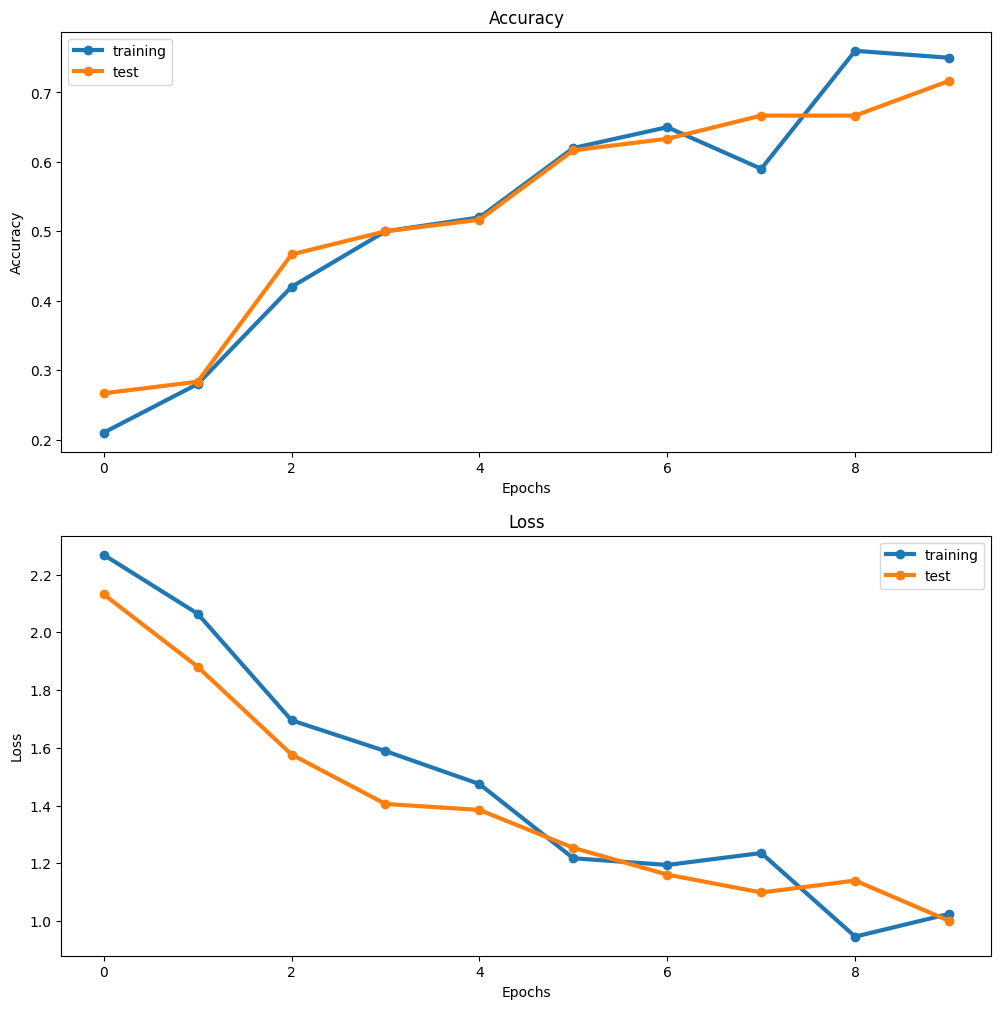

In [7]:

#Unzip images (delete folder images in case it exists)
!rm -r images
!unzip /content/images.zip -d /content/

#Build a tensorflow dataset using the uploaded images
build = tfds.ImageFolder('/content/images')
train_data = build.as_dataset(split='train', shuffle_files=True)
test_data = build.as_dataset(split='test', shuffle_files=True)

#Show some images in the training dataset
tfds.show_examples(train_data, build.info)

#Learn a classifier by finetuning a BiT-M model (ResNet50x1 model trained on ImageNet-21k)
module=hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1")
#Create a new model with a new final layer that has the correct number of output classes
class BiT(tf.keras.Model):
  def __init__(self, num_classes, mod):
    super().__init__()
    self.num_classes=num_classes
    self.head=tf.keras.layers.Dense(num_classes,kernel_initializer='zeros')
    self.bit_model=mod

  def call(self,images):
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)
model=BiT(num_classes=10,mod=module)

#Fine-tune this model using BiT-HyperRule
image_size = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
#Alternatively, set image_size = "> 96 x 96 px" #@param ["=<96x96 px","> 96 x 96 px"]
dataset_size = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]
#Resize and crop images
if image_size == "=<96x96 px":
  resize_to = 160
  crop_to = 128
else:
  resize_to = 512
  crop_to = 480
#Training steps
if dataset_size == "<20k examples":
  schedule_length = 500
  schedule_boundaries = [200, 300, 400]
elif dataset_size == "20k-500k examples":
  schedule_length = 10000
  schedule_boundaries = [3000, 6000, 9000]
else:
  schedule_length = 20000
  schedule_boundaries = [6000, 12000, 18000]


#Preprocessing
batch_size = 10
schedule_length = schedule_length * 512 / batch_size
steps_per_epoch= 10


def cast_to_tuple(features):
  return (features['image'], features['label'])

#Preprocess train  images
def preprocess_train(features):
  #Apply horizontal flips
  # features['image'] = tf.image.random_flip_left_right(features['image'])
  #Resize
  features['image'] = tf.image.resize(features['image'], [resize_to, resize_to])
  #Apply random crop
  features['image'] = tf.image.random_crop(features['image'], [crop_to, crop_to, 3])
  #Min-max scaling
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features
#Preprocess test images
def preprocess_test(features):
  #Resize
  features['image'] = tf.image.resize(features['image'], [resize_to, resize_to])
  #Min-max scaling
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features
#Pipelines
num_train_examples=build.info.splits['train'].num_examples
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_pipeline = (train_data
                  .shuffle(1000)
                  .repeat(int(schedule_length * batch_size / num_train_examples * steps_per_epoch))
                  .map(preprocess_train)
                  .batch(batch_size)
                  .map(cast_to_tuple)
                  .prefetch(AUTOTUNE))

test_pipeline = (test_data
                 .map(preprocess_test)
                 .batch(batch_size)
                 .map(cast_to_tuple)
                 .prefetch(AUTOTUNE))


#Fine-tuning loop
#learning rate
lr = 0.003 * batch_size / 512
#we decay the learning rate by a factor of 10 at 30%, 60% and 90% of the training steps (schedule_boundaries)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=schedule_boundaries,
                                                                  values=[lr, lr*0.1, lr*0.001, lr*0.0001])
#we use SGD with lr_schedule learning rate and momentum 0.9
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
#loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#compile the model
model.compile(optimizer=optimizer,
             loss=loss_fn,
             metrics=['accuracy'])

#Fine-tune model
history=model.fit(
   train_pipeline,
   batch_size=10,
   epochs=10,
   steps_per_epoch=10,
   validation_data=test_pipeline)

#learning curve
def learning_curve(history, lw = 3):
    plt.figure(figsize=(12,12))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'], label = 'training', marker = 'o', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'test', marker = 'o', linewidth = lw)
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label = 'training', marker = 'o', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'test', marker = 'o', linewidth = lw)
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

learning_curve(history)
